# Classificação de imagens de desenho animado

In [1]:
import cv2
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

Configurando as variáveis para trabalhar com o diretório Base_de_Dados

In [2]:
# Defina uma variável global para armazenar o modelo treinado
global model
model = None

# Obtenha o diretório atual de trabalho
script_dir = os.getcwd()

# Define o diretório onde suas imagens estão localizadas
data_dir = os.path.join(script_dir, 'Base_de_Dados')

Preparando as imagens para serem usadas. (usando pré-processamento de imagens)

In [3]:
def preprocess_image(img_path):
    # Carregue a imagem original
    imagem = cv2.imread(img_path)

    # Verifique se a imagem foi carregada com sucesso
    if imagem is None:
        print(f"Erro ao carregar a imagem: {img_path}")
        return None  # Retorne None para indicar que o processamento falhou

    # Redimensionando a imagem
    imagem_redimensionada = cv2.resize(imagem, (224, 224))

    # Aumento de contraste
    imagem_em_escala_de_cinza = cv2.cvtColor(imagem_redimensionada, cv2.COLOR_BGR2GRAY)

    imagem_processada = imagem_em_escala_de_cinza / 255.0

    # Retorne a imagem processada
    return imagem_processada

 Preparação dos dados para treinamento e validação do modelo.

In [4]:
# Use ImageDataGenerator para carregar os dados
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)  # Normalização

# Carregue os dados em um array numpy
image_data = []
image_labels = []

for subdir in os.listdir(data_dir):
    sub_dir_path = os.path.join(data_dir, subdir)
    if os.path.isdir(sub_dir_path):
        for img_file in os.listdir(sub_dir_path):
            img_path = os.path.join(sub_dir_path, img_file)
            image_data.append(img_path)
            image_labels.append(subdir)

image_data = np.array(image_data)
image_labels = np.array(image_labels)
labels = np.unique(image_labels)

# Defina o número de folds
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Variáveis para armazenar resultados
all_train_histories = []
all_val_histories = []
confusion_matrices = []

# Defina o valor de batch_size
batch_size = 32  # Você pode ajustar esse valor conforme necessário

 Treinando o modelo de classificação de imagens usando validação cruzada:

In [5]:
def treino(nome_do_modelo):
    global model  # Use a variável global

    # Variável para armazenar informações de cada fold
    fold_info = []

    # Loop através dos folds
    for i, (train_index, val_index) in enumerate(kf.split(image_data), 1):
        train_data = image_data[train_index]
        train_labels = image_labels[train_index]
        val_data = image_data[val_index]
        val_labels = image_labels[val_index]

        # Pré-processar as imagens de treinamento e validação
        train_data_processed = [preprocess_image(img_path) for img_path in train_data]
        val_data_processed = [preprocess_image(img_path) for img_path in val_data]

        # Remova entradas None (imagens que não puderam ser carregadas)
        train_data_processed = [img for img in train_data_processed if img is not None]
        val_data_processed = [img for img in val_data_processed if img is not None]

        # Converter as imagens em listas de matrizes 1D
        train_data_processed = [img.flatten() for img in train_data_processed]
        val_data_processed = [img.flatten() for img in val_data_processed]

        # Converta as listas em arrays numpy
        train_data_processed = np.array(train_data_processed)
        val_data_processed = np.array(val_data_processed)

        train_df = pd.DataFrame({'filename': train_data, 'class': train_labels})
        val_df = pd.DataFrame({'filename': val_data, 'class': val_labels})

        train_generator = datagen.flow_from_dataframe(
            dataframe=train_df,
            x_col='filename',
            y_col='class',
            target_size=(224, 224),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True
        )

        val_generator = datagen.flow_from_dataframe(
            dataframe=val_df,
            x_col='filename',
            y_col='class',
            target_size=(224, 224),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False
        )

        num_classes = len(np.unique(train_labels))

        # Crie e compile o modelo
        model = tf.keras.models.Sequential()

        ## Onde ocorre as mudanças em relação ao algoritmo padrão e o aprimorado

        # Camadas convolucionais e de pooling
        model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))
        model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))
        model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))
        # Flatten para camadas densas
        model.add(tf.keras.layers.Flatten())
        # Camadas densas
        model.add(tf.keras.layers.Dense(512, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.5))  # Dropout para reduzir o overfitting
        model.add(tf.keras.layers.Dense(512, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.5))  # Dropout para reduzir o overfitting
        # Camada de saída
        model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

        ## Fim das diferenças

        # Compile o modelo
        model.compile(optimizer='rmsprop',
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'])

        # Treine o modelo por 5 época (ou o número de épocas desejado)
        history = model.fit(train_generator, epochs=5, validation_data=val_generator)

        # Avalie o modelo no conjunto de teste (val_generator)
        y_true = val_generator.classes  # Rótulos reais
        y_pred_probs = model.predict(val_generator)  # Probabilidades das previsões
        y_pred = np.argmax(y_pred_probs, axis=1)  # Rótulos previstos

        # Calcule a matriz de confusão
        cm = confusion_matrix(y_true, y_pred)

        # Calcula a precisão para cada classe
        num_classes = cm.shape[0]
        precisao_por_classe = []
        for classe in range(num_classes):
            TP = cm[classe, classe]  # Verdadeiros Positivos
            FP = np.sum(cm[:, classe]) - TP  # Falsos Positivos
            precision = TP / (TP + FP)
            precisao_por_classe.append(precision)

        # Armazena informações do fold em fold_info
        fold_info.append({
            'Fold': i,
            'Loss': history.history['loss'],
            'Accuracy': history.history['accuracy'],
            'Validation Loss': history.history['val_loss'],
            'Validation Accuracy': history.history['val_accuracy'],
            'Confusion Matrix': cm,
            'Precision per Class': precisao_por_classe
        })

    # Salve o modelo treinado com o nome especificado
    model.save(nome_do_modelo)

    # Retorne o modelo e as informações de cada fold
    return model, fold_info


**Camadas usadas no algoritmo padrão**

-  Camada convolucional e de pooling  
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))  
model.add(tf.keras.layers.MaxPooling2D((2, 2)))  
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))  
model.add(tf.keras.layersMaxPooling2D((2, 2)))  
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))  

- Flatten para camadas densas  
model.add(tf.keras.layers.Flatten())  

- Camada densa  
model.add(tf.keras.layers.Dense(64, activation='relu'))  

- Camada de saída  
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))  


**Camadas usadas no algoritmo aprimorado**

- Camadas convolucionais e de pooling   
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))  
model.add(tf.keras.layers.MaxPooling2D((2, 2)))  
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))  
model.add(tf.keras.layers.MaxPooling2D((2, 2)))  
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))  
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

- Flatten para camadas densas    
model.add(tf.keras.layers.Flatten())

- Camadas densas  
model.add(tf.keras.layers.Dense(512, activation='relu'))  
model.add(tf.keras.layers.Dropout(0.5))  # Dropout para reduzir o overfitting  
model.add(tf.keras.layers.Dense(512, activation='relu'))  
model.add(tf.keras.layers.Dropout(0.5))  # Dropout para reduzir o overfitting

- Camada de saída  
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))  

Calculando a matriz de confusão geral e a precisão por classe com base nas matrizes de confusão:

In [6]:
def calcular_matriz_confusao_e_precisao(model, nome_do_modelo, labels, confusion_matrices):
    # Crie a matriz de confusão geral
    overall_confusion_matrix = np.sum(confusion_matrices, axis=0)

    # Calcula a precisão para cada classe
    num_classes = overall_confusion_matrix.shape[0]
    precisao_por_classe = []

    for classe in range(num_classes):
        TP = overall_confusion_matrix[classe, classe]  # Verdadeiros Positivos
        FP = np.sum(overall_confusion_matrix[:, classe]) - TP  # Falsos Positivos
        precision = TP / (TP + FP)
        precisao_por_classe.append(precision)

    return {
        'Matriz de Confusão Geral': overall_confusion_matrix,
        'Precisão por Classe': precisao_por_classe
    }

Exibe as informações sobre o treinamento e validação de um modelo de classificação ao longo dos diferentes folds da validação cruzada.  
    Monitorar e analisa o desempenho de um modelo de classificação

In [7]:
# Função para exibir informações de cada fold
def exibir_informacoes_fold(fold_info, labels):

    if (fold_info == []):
        print("Não possui os dados do treinamento e validação do modelo")
        return None

    all_accuracy = []
    all_val_accuracy = []
    all_precision = []
    all_confusion_matrices = []

    for fold_data in fold_info:
        fold = fold_data['Fold']
        loss = fold_data['Loss']
        accuracy = fold_data['Accuracy']
        val_loss = fold_data['Validation Loss']
        val_accuracy = fold_data['Validation Accuracy']
        confusion_matrix_fold = fold_data['Confusion Matrix']
        precisao_por_classe_fold = fold_data['Precision per Class']

        print(f'Fold {fold}:')
        print(f'Loss: {loss}')
        print(f'Accuracy: {accuracy}')
        print(f'Validation Loss: {val_loss}')
        print(f'Validation Accuracy: {val_accuracy}')

        print("Matriz de Confusão:")
        print(confusion_matrix_fold)

        print("\nPrecisão por Classe:")
        for classe, precision in enumerate(precisao_por_classe_fold):
            classe_nome = labels[classe]
            print(f"Classe '{classe_nome}': Precisão = '{precision:.4f}'")

        all_accuracy.append(accuracy[-1])
        all_val_accuracy.append(val_accuracy[-1])
        all_precision.append(precisao_por_classe_fold)
        all_confusion_matrices.append(confusion_matrix_fold)

    num_folds = len(fold_info)

    # Calcular médias
    average_accuracy = np.mean(all_accuracy)
    average_val_accuracy = np.mean(all_val_accuracy)
    average_precision = np.mean(all_precision, axis=0)

    print(f'\nAcurácia Média entre os {num_folds} folds: {average_accuracy:.4f}')
    print(f'Acurácia de Validação Média entre os {num_folds} folds: {average_val_accuracy:.4f}')

    # Calcular a matriz de confusão geral (somatório das matrizes dos folds)
    confusion_matrix_general = np.sum(all_confusion_matrices, axis=0)

    print("\nMatriz de Confusão Geral (Somatório das Matrizes dos Folds):")
    print(confusion_matrix_general)

    print("\nPrecisão Média por Classe:")
    for classe, precision in enumerate(average_precision):
        classe_nome = labels[classe]
        print(f"Classe '{classe_nome}': Precisão Média = '{precision:.4f}'")


Carrega um modelo previamente treinado se ele já existir ou treinar um novo modelo se ele não existe.

In [8]:
def carregar_ou_treinar_modelo(nome_do_modelo):

    # Obtenha o caminho do diretório atual
    diretorio_atual = os.getcwd()

    # Inicialize fold_info como uma lista vazia
    fold_info = []

    # Verifique se o modelo já existe
    if os.path.exists(nome_do_modelo):
        # Se o modelo existir, carregue-o
        model = tf.keras.models.load_model(nome_do_modelo)

    else:
        # Se o modelo não existir, treine-o
        model, fold_info = treino(nome_do_modelo)

    return model, fold_info

Pré-processa uma imagem de forma que possa ser usada para fazer previsões com um modelo treinado.

In [9]:
def preprocess_image_for_prediction(img_path):
    # Carregue a imagem original
    imagem_processada = preprocess_image(img_path)

    # Expanda as dimensões para corresponder à forma esperada do modelo (1, 224, 224, 3)
    imagem_processada = np.expand_dims(imagem_processada, axis=0)
    imagem_processada = np.stack((imagem_processada,) * 3, axis=-1)  # Replica o canal em todos os três canais
    imagem_processada = np.expand_dims(imagem_processada, axis=-1)

    return imagem_processada

 Faz a classificação de uma imagem usando um modelo de aprendizado de máquina pré-treinado (ou treinado na hora).

In [10]:
# Função para fazer a classificação da imagem
def classificar_imagem(imagem_path, nome_do_modelo):
    model, _ = carregar_ou_treinar_modelo(nome_do_modelo)  # Carrega ou treina o modelo
    # Pré-processamento da imagem
    imagem_processada = preprocess_image_for_prediction(imagem_path)

    if imagem_processada is None:
        return "Falha no pré-processamento", None

    # Faça a previsão usando o modelo
    previsao = model.predict(imagem_processada)

    # Obtenha a classe prevista com a maior probabilidade
    classe_prevista = np.argmax(previsao)

    # Imprima as classes previstas e suas probabilidades
    print(f"\n\nResultado da classificação para a imagem: {imagem_path} usando o modelo: {nome_do_modelo}")
    print("\nClassificação das 3 classes mais prováveis:")
    top_classes_indices = np.argsort(previsao[0])[::-1][:3]
    top_classes_names = [labels[i] for i in top_classes_indices]
    top_classes_probs = [previsao[0][i] for i in top_classes_indices]
    for i, (classe, probabilidade) in enumerate(zip(top_classes_names, top_classes_probs), 1):
        print(f"{i}. Classe: {classe}, Probabilidade: {probabilidade:.4f}")

    # Imprima todas as classes e suas probabilidades
    print("\nProbabilidades para todas as classes:")
    for i, (classe, probabilidade) in enumerate(zip(labels, previsao[0]), 1):
        print(f"{classe}, Probabilidade: {probabilidade:.4f}")

    return labels[classe_prevista], previsao[0][classe_prevista]

In [11]:
# Especifique o nome do modelo desejado
nome_do_modelo = 'mudando_camadas5.keras'

# Carregue ou treine o modelo e obtenha as informações/estatísticas do fold
model, fold_info = carregar_ou_treinar_modelo(nome_do_modelo)

In [12]:
script_dir = os.getcwd()
imagem_path = os.path.join(script_dir, 'frame_12210.jpg')

# Realize a classificação da imagem com o modelo já carregado
classe_prevista = classificar_imagem(imagem_path, nome_do_modelo)
print(f'O nome da classe prevista é: {classe_prevista}\n')

1/1 [==============================] - 23s 23s/step


Resultado da classificação para a imagem: e:\zzzzzanime\frame_12210.jpg usando o modelo: mudando_camadas5.keras

Classificação das 3 classes mais prováveis:
1. Classe: Padrinhos_Magicos, Probabilidade: 1.0000
2. Classe: Pica_Pau, Probabilidade: 0.0000
3. Classe: Apenas_Um_Show, Probabilidade: 0.0000

Probabilidades para todas as classes:
Apenas_Um_Show, Probabilidade: 0.0000
Bob_Esponja, Probabilidade: 0.0000
Bungo_Stray_Dogs, Probabilidade: 0.0000
Kick_Buttowski, Probabilidade: 0.0000
Looney_Tunes, Probabilidade: 0.0000
Madeline, Probabilidade: 0.0000
Padrinhos_Magicos, Probabilidade: 1.0000
Pica_Pau, Probabilidade: 0.0000
O nome da classe prevista é: ('Padrinhos_Magicos', 1.0)



In [13]:
# Exiba as informações/estatísticas do fold
exibir_informacoes_fold(fold_info, labels)

Não possui os dados do treinamento e validação do modelo


# Testes estatísticos

In [14]:
import matplotlib.pyplot as plt
from scipy import stats

Função para exibir o histograma dos dados

    Serão passados os dados da acurácia de validação final de cada fold, foram pegos um total de 25 dados de acurácia para cada algoritmo analisado.



In [15]:
def plot_histogram(valores, bins=10, xlim=None, ylim=None):
    # Crie o histograma
    plt.hist(valores, bins=bins, edgecolor='k', alpha=0.75)

    # Defina os limites dos eixos X e Y, se fornecidos
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    # Adicione rótulos e título
    plt.xlabel('Valores')
    plt.ylabel('Frequência')
    plt.title('Histograma')

    # Exiba o gráfico
    plt.show()

Função para verificar se os dados passados tem uma distribuição normal

    Será usado o teste de Shapiro

In [16]:
def teste_normalidade(sample):
    # Aplicando o teste de Shapiro-Wilk
    statistic, p_value = stats.shapiro(sample)

    # Verificando o resultado
    if p_value > 0.05:
        print("A amostra parece ser normal.")
    else:
        print("A amostra não parece ser normal.")

    plot_histogram(sample, xlim=(0.5, 1.0))

Passando os dados obtidos da validação de acurácia do algoritmo **"padrão"** e realizando o teste de normalidade

A amostra não parece ser normal.


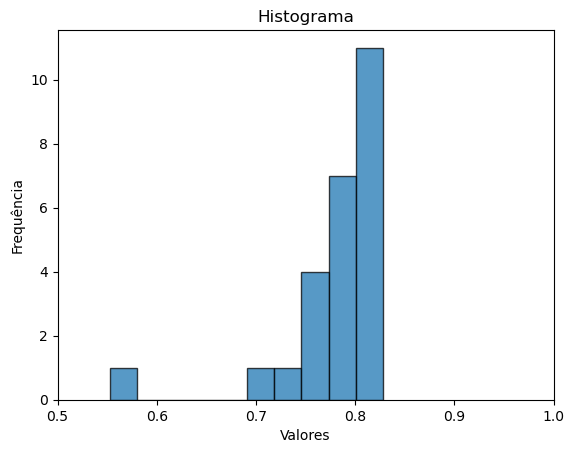

In [17]:
padrao = [
    0.7685112953186035, 0.8074824810028076, 0.8129384517669678, 0.7755261063575745, 0.8285269141197205,
    0.8082618713378906, 0.7466874718666077, 0.7575993537902832, 0.8082618713378906, 0.8067030310630798,
    0.7747467160224915, 0.7887762784957886, 0.7950116991996765, 0.7427903413772583, 0.784879207611084,
    0.7973499894142151, 0.8012470602989197, 0.5526110529899597, 0.7084957361221313, 0.8285269141197205,
    0.8191738128662109, 0.8098207116127014, 0.7560405135154724, 0.8152766823768616, 0.7817614674568176
]

teste_normalidade(padrao)

Passando os dados obtidos da validação de acurácia do algoritmo **"aprimorado"** e realizando o teste de normalidade

A amostra não parece ser normal.


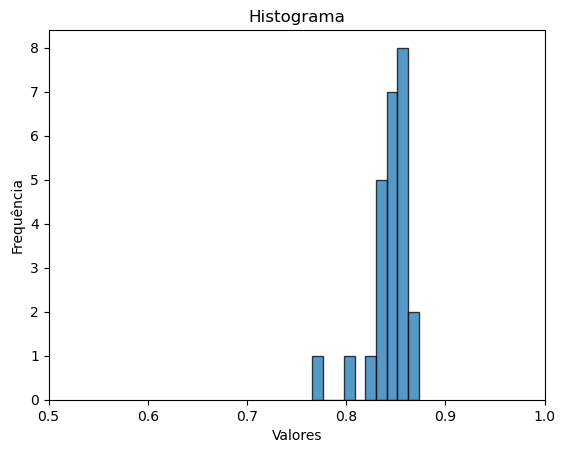

In [18]:
aprimorado = [
    0.8409976363182068, 0.8472330570220947, 0.8409976363182068, 0.7653936147689819, 0.8300857543945312,
    0.8503507375717163, 0.8511301875114441, 0.8519095778465271, 0.8558067083358765, 0.8550272583961487,
    0.8667186498641968, 0.8378799557685852, 0.8456742167472839, 0.8409976363182068, 0.8729540109634399,
    0.8612626791000366, 0.8573655486106873, 0.8254091739654541, 0.8332034349441528, 0.8620420694351196,
    0.8347622752189636, 0.8573655486106873, 0.7989088296890259, 0.8558067083358765, 0.8347622752189636
]
teste_normalidade(aprimorado)

Função para verificar se os algoritmos são estatisticamentes "iguais" e exibir o bloxplot da distribuição de ambos

    Caso eles sejam estatisticamente diferentes serão apontado qual deles é o melhor (possui maior acurácia)
    Pelos testes feitos as amostras não seguem uma distribuição normal, dessa forma, será realizado o teste de Mann-Whitney

In [19]:
def comparar_algoritmos(amostra1, amostra2, alpha=0.05):
    # Realize o teste de Mann-Whitney U
    stat, p = stats.mannwhitneyu(amostra1, amostra2, alternative='two-sided')

    # Plote um gráfico de caixa para cada amostra
    plt.figure(figsize=(8, 6))
    plt.boxplot([amostra1, amostra2], labels=['Algoritmo 1', 'Algoritmo 2'])
    plt.title('Comparação de Algoritmos')
    plt.ylabel('Acurácia')

    # Calcule medidas resumo
    media_amostra1 = round(sum(amostra1) / len(amostra1), 2)
    media_amostra2 = round(sum(amostra2) / len(amostra2), 2)

    # Adicione informações sobre a média no gráfico
    plt.text(1, max(amostra1) - 0.01, f'Média: {media_amostra1}', ha='center')
    plt.text(2, max(amostra2) - 0.01, f'Média: {media_amostra2}', ha='center')

    # Adicione resultado do teste ao gráfico
    if p < alpha:
        if media_amostra1 > media_amostra2:
            plt.text(1.5, max(max(amostra1), max(amostra2)) - 0.02, 'Algoritmo padrão é melhor', ha='center', color='green')
        else:
            plt.text(1.5, max(max(amostra1), max(amostra2)) - 0.02, 'Algoritmo aprimorado é melhor', ha='center', color='green')
    else:
        plt.text(1.5, max(max(amostra1), max(amostra2)) - 0.02, 'Não há diferença significativa', ha='center', color='red')

    plt.show()

    # Retorne o resultado do teste e qual algoritmo é considerado melhor ou se não há diferença significativa
    if p < alpha:
        if media_amostra1 > media_amostra2:
            return "Algoritmo padrão é melhor"
        else:
            return "Algoritmo aprimorado é melhor"
    else:
        return "Não há diferença significativa"

## Resultado final

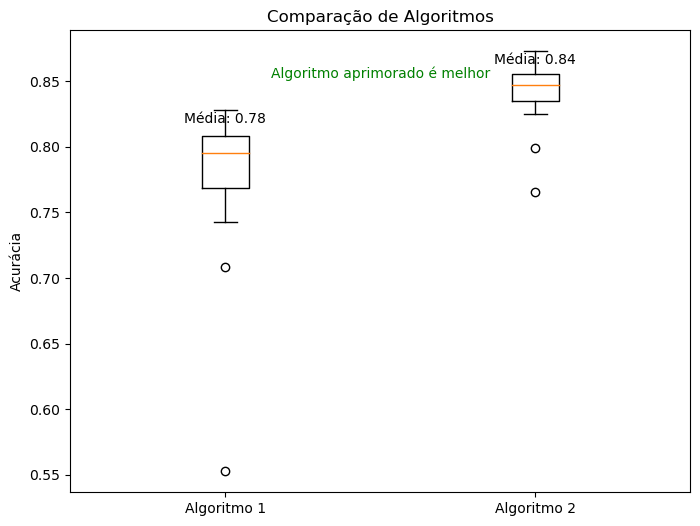

Algoritmo aprimorado é melhor


In [20]:
resultado = comparar_algoritmos(padrao, aprimorado)
print(resultado)

# Realizando teste de classificação aleatoriamente

Escolher aleatoriamente uma imagem disponível no banco de dados, na pasta "Base_de_Dados"

In [21]:
import random

def sortear_imagem():
    data_dir = os.path.join(script_dir, 'Base_de_Dados')
    classes = os.listdir(data_dir)
    classe_aleatoria = random.choice(classes)
    caminho_da_classe = os.path.join(data_dir, classe_aleatoria)
    imagens_da_classe = os.listdir(caminho_da_classe)
    imagem_aleatoria = random.choice(imagens_da_classe)
    caminho_da_imagem_sorteada = os.path.join(caminho_da_classe, imagem_aleatoria)
    
    return caminho_da_imagem_sorteada
    

In [23]:
imagem_sorteada = sortear_imagem()

classe_prevista_padrao = classificar_imagem(imagem_sorteada, "cnn_padrao5.keras")
classe_prevista_aprimorado = classificar_imagem(imagem_sorteada, "mudando_camadas5.keras")


1/1 [==============================] - 0s 251ms/step


Resultado da classificação para a imagem: e:\zzzzzanime\Base_de_Dados\Apenas_Um_Show\frame_30470.jpg usando o modelo: cnn_padrao5.keras

Classificação das 3 classes mais prováveis:
1. Classe: Apenas_Um_Show, Probabilidade: 0.9998
2. Classe: Kick_Buttowski, Probabilidade: 0.0001
3. Classe: Bungo_Stray_Dogs, Probabilidade: 0.0000

Probabilidades para todas as classes:
Apenas_Um_Show, Probabilidade: 0.9998
Bob_Esponja, Probabilidade: 0.0000
Bungo_Stray_Dogs, Probabilidade: 0.0000
Kick_Buttowski, Probabilidade: 0.0001
Looney_Tunes, Probabilidade: 0.0000
Madeline, Probabilidade: 0.0000
Padrinhos_Magicos, Probabilidade: 0.0000
Pica_Pau, Probabilidade: 0.0000
1/1 [==============================] - 2s 2s/step


Resultado da classificação para a imagem: e:\zzzzzanime\Base_de_Dados\Apenas_Um_Show\frame_30470.jpg usando o modelo: mudando_camadas5.keras

Classificação das 3 classes mais prováveis:
1. Classe: Apenas_Um_Show, Probabilidade: 0.95